In [1]:
import edward as ed
from edward.models import Normal

from keras.layers import Input, Dense
from keras.regularizers import l2
from keras import backend as K

import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.preprocessing import scale

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
plt.style.use('seaborn')
%matplotlib inline

Using TensorFlow backend.


In [2]:
sess = ed.get_session()
K.set_session(sess)

INIT_OP = tf.global_variables_initializer()

In [3]:
data = properties_df = pd.read_csv('train.csv',low_memory=False)

In [4]:
keep_cols = data.columns[data.isnull().mean() < .25]
data = data[keep_cols]

In [5]:
cols = [col for col in data.columns if data[col].dtype == np.float64]

In [6]:
DF = 10 # of desired features
Features = data[keep_cols].corr()['SalePrice'].abs().sort_values(ascending=False).head(10)[1:DF]
Features = Features.index

In [7]:
data.dropna(inplace=True)
data.reset_index(inplace=True)

C:\Users\aresf\Anaconda3\envs\py36\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [8]:
fixed_effect_predictors = Features
# fixed_effect_predictors = [
#     'GrLivArea',
#     'YearBuilt',
#     'GarageArea'
# ]

In [31]:
zip_codes = data['Neighborhood'].astype('category').cat.codes

In [10]:
train_index = data.sample(frac=0.5).index
val_index = data.drop(train_index).index

X = scale(data.drop('SalePrice',axis=1)[fixed_effect_predictors])
y = scale(data['SalePrice'].values)

X_train = X[train_index]
y_train = y[train_index]
X_val = X[val_index]
y_val = y[val_index]

print('Dataset sizes:')
print(f'    X_train: {X_train.shape}')
print(f'    y_train: {y_train.shape}')

Dataset sizes:
    X_train: (547, 9)
    y_train: (547,)


C:\Users\aresf\Anaconda3\envs\py36\lib\site-packages\sklearn\utils\validation.py:444: DataConversionWarning: Data with input dtype int64 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)


In [11]:
N, D = X_train.shape
fixed_effects = tf.placeholder(tf.float32, [N, D])

# The model is of the form mu = A + Bx

B_fixed_effects = Normal(loc=tf.zeros(D), scale=tf.ones(D))
A = Normal(loc=tf.zeros(1), scale=tf.ones(1))

# model

M_y = A + ed.dot(fixed_effects, B_fixed_effects)
y = Normal(loc=M_y, scale=tf.ones(N))

# approximate distributions

qB_fixed_effects = Normal(
    loc=tf.Variable(tf.random_normal([D])),
    scale=tf.nn.softplus(tf.Variable(tf.random_normal([D])))
)

qA = Normal(
    loc=tf.Variable(tf.random_normal([1])),
    scale=tf.nn.softplus(tf.Variable(tf.random_normal([1])))
)


In [21]:
# Infer parametrons

latent_vars = {
    B_fixed_effects: qB_fixed_effects,
    A: qA
}

sess.run(INIT_OP)
inference = ed.KLqp(latent_vars, data={fixed_effects: X_train, y: y_train})
inference.run(n_samples=10, n_iter=800)

800/800 [100%] ██████████████████████████████ Elapsed: 13s | Loss: 609.800


In [22]:
def visualize_data_fit(X, y, B, A, title_prefix, n_samples=10):
    B_samples = B.sample(n_samples).eval()
    A_samples = A.sample(n_samples).eval()
    
    fig = plt.figure(figsize=(12, 9))
    ax = plt.axes(projection='3d')
    ax.scatter(X[:, 0], X[:, 1], y)
    plt.title(f'{title_prefix} Parameter Samples vs. Observed Data')
    
    inputs = np.linspace(-10, 10, num=500)
    for i in range(n_samples):
        output = inputs * B_samples[i][0] + inputs*B_samples[i][1]
        ax.plot(inputs, inputs, output)

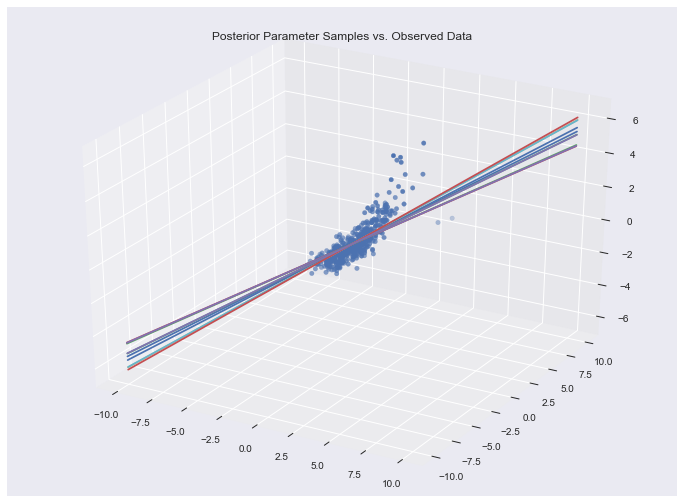

In [23]:
visualize_data_fit(X_train, y_train, qB_fixed_effects, qA, 'Posterior', n_samples=10)

In [47]:
# Inspect residulers

def compute_MAE(y_posterior, X_val_feed_dict, y_val=y_val):
    data = {y_posterior: y_val}
    data.update(X_val_feed_dict)
    mae = np.sqrt(ed.evaluate('mean_squared_error', data=data))
    print(f'MAE on validation data: {mae:1.5}')
    
def compute_RMSE(y_posterior, X_val_feed_dict, y_val=y_val):
    data = {y_posterior: y_val}
    data.update(X_val_feed_dict)
#     rmse = ed.evaluate
    
def plot_residuals(y_posterior, X_val_feed_dict, title, y_val=y_val):
    y_posterior_preds = y_posterior.eval(feed_dict=X_val_feed_dict)
    plt.figure(figsize=(9, 6))
    fn = np.sqrt(np.power(y_posterior_preds-y_val, 2))
    plt.hist(fn, edgecolor='white',
             linewidth=1, bins=30, alpha= .7)
    plt.axvline(0, color='r', linestyle='--')
    plt.xlabel('Yposterior - Yval', fontsize=14)
    plt.title(title,fontsize=16)


In [25]:
param_posteriors = {
    B_fixed_effects: qB_fixed_effects.mean(),
    A: qA.mean()
}

X_val_feed_dict = {
    fixed_effects: X_val
}

y_posterior = ed.copy(y, param_posteriors)

In [26]:
print(f'Mean validation price: {y_val.mean()}')
compute_MAE(y_posterior, X_val_feed_dict)

Mean validation price: -0.023263186663810973
MAE on validation data: 0.48187


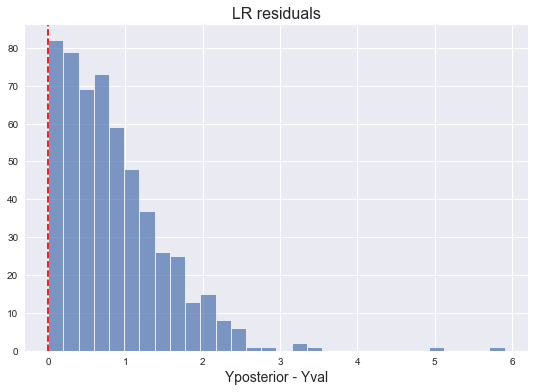

In [48]:
plot_residuals(y_posterior, X_val_feed_dict, title='LR residuals')

Text(0.5,1,'Posterior Distribution of Fixed Intercept α')

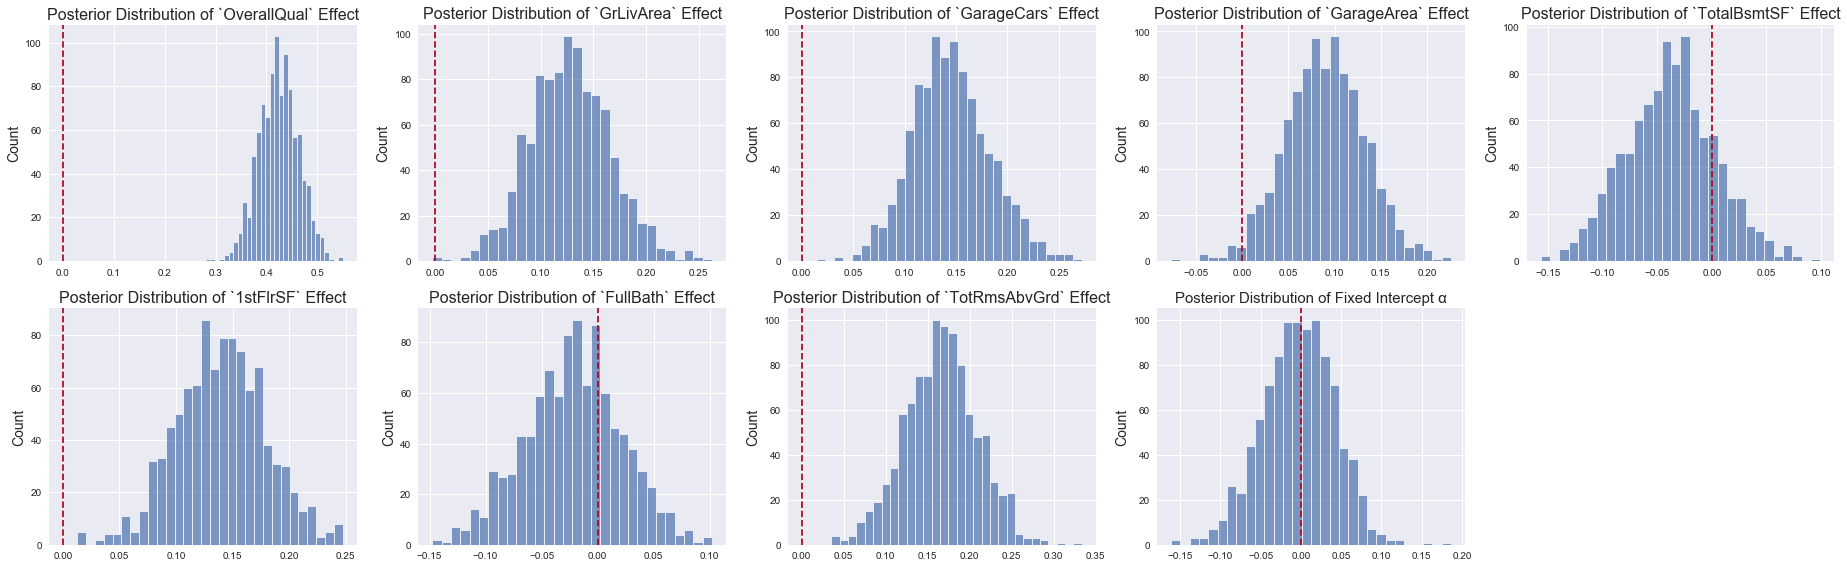

In [28]:
# draw samples from posteriors
qβ_fixed_effects_samples = qB_fixed_effects.sample(1000).eval()
qα_samples = qA.sample(1000).eval()

# plot samples
plt.figure(figsize=(32, 20))

for dimension in range(D-1):
    subplot = plt.subplot(451 + dimension)
    plt.hist(qβ_fixed_effects_samples[:, dimension], edgecolor='white', linewidth=1, bins=30, alpha=.7)
    plt.axvline(0, color='#A60628', linestyle='--')
    title = f'Posterior Distribution of `{fixed_effect_predictors[dimension]}` Effect'
    plt.ylabel('Count', fontsize=14)
    plt.title(title, fontsize=16)
    
subplot = plt.subplot(451 + dimension + 1)
plt.hist(qα_samples, edgecolor='white', linewidth=1, bins=30, alpha=.7)
plt.axvline(0, color='#A60628', linestyle='--')
title = f'Posterior Distribution of Fixed Intercept α'
plt.ylabel('Count', fontsize=14)
plt.title(title, fontsize=15)

In [32]:
# Random Effects model: describes "clusters" of observations,
# walking the line between global expectations and within-cluster expectations
# The random effects expectations will follow the local ones but shrunk towards 
# the global expectation
# (pretty cool)

n_zip_codes = len(set(Neighborhood))
# Write neighborhoods as zipcodes to facilitate copying from tutorial
zip_codes_ph = tf.placeholder(tf.int32, [N])

sigma_zip_code = tf.sqrt(tf.exp(tf.Variable(tf.random_normal([]))))
A_zip_code = Normal(loc=tf.zeros(n_zip_codes), scale=sigma_zip_code * tf.ones(n_zip_codes))

A_random_effects = tf.gather(A_zip_code, zip_codes_ph)
M_y = A + A_random_effects + ed.dot(fixed_effects, B_fixed_effects)
y = Normal(loc=M_y, scale=tf.ones(N))

# Approximating distribution
qA_zip_code = Normal(
    loc=tf.Variable(tf.random_normal([n_zip_codes])),
    scale=tf.nn.softplus(tf.Variable(tf.random_normal([n_zip_codes])))
)

In [33]:
# Inference! 

latent_vars = {
    B_fixed_effects: qB_fixed_effects,
    A: qA,
    A_zip_code: qA_zip_code
}

sess.run(INIT_OP)
inference = ed.KLqp(latent_vars, data={fixed_effects: X_train,
                                      zip_codes_ph: zip_codes[train_index],
                                      y: y_train})
inference.run(n_samples=5, n_iter=250)

250/250 [100%] ██████████████████████████████ Elapsed: 7s | Loss: 627.530


In [34]:
param_posteriors = {
    B_fixed_effects: qB_fixed_effects.mean(),
    A: qA.mean(),
    A_zip_code: qA_zip_code.mean()
}
X_val_feed_dict = {
    fixed_effects: X_val,
    zip_codes_ph: zip_codes[val_index]
}
y_posterior = ed.copy(y, param_posteriors)

In [35]:
compute_MAE(y_posterior, X_val_feed_dict)

MAE on validation data: 0.4831


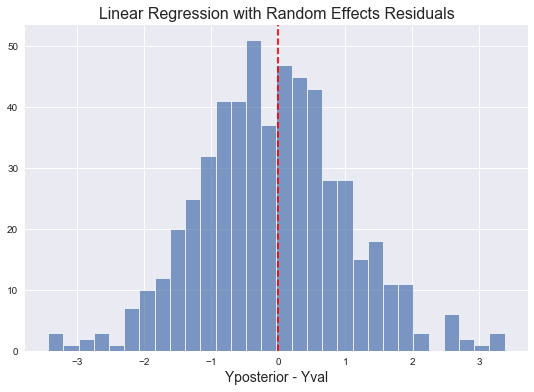

In [36]:
plot_residuals(y_posterior, X_val_feed_dict,
               title='Linear Regression with Random Effects Residuals')

In [37]:
# Estimate random-effects intercepts

M_y = A + A_random_effects
y = Normal(loc=M_y, scale=tf.ones(N))

latent_vars = {
    A: qA,
    A_zip_code: qA_zip_code
}

In [38]:
# Infer them
sess.run(INIT_OP)
inference = ed.KLqp(latent_vars, data={zip_codes_ph: zip_codes[train_index],
                                       y: y_train})
inference.run(n_samples=5, n_iter=250)

global_intercept_posterior_mean = qA.mean().eval()

random_effects_posterior_means = global_intercept_posterior_mean + qA_zip_code.mean().eval()

random_effects_posterior_means = pd.Series(
    random_effects_posterior_means, index=range(0, n_zip_codes),
    name='random_effects_posterior_means'
)


250/250 [100%] ██████████████████████████████ Elapsed: 6s | Loss: 667.556


In [39]:
# Same for within-cluster interecepts

# select a few clusters of varying size
zip_codes_df = pd.DataFrame({'cluster_size': zip_codes[train_index].value_counts()})
zip_codes_df['cluster_size_group'] = pd.cut(zip_codes_df['cluster_size'], 3, labels=['small', 'medium', 'large'])
zip_codes_df = zip_codes_df.groupby('cluster_size_group').head(20)

# build individual models for each cluster
within_cluster_posterior_means = {}

for zip_code in zip_codes_df.index.unique():
    # compute mask, number of observations
    mask = zip_codes[train_index] == zip_code
    N_ = mask.sum()
    
    # instantiate model for current cluster
    fixed_effects = tf.placeholder(tf.float32, [N_, D])
    M_y = A
    y = Normal(loc=M_y, scale=tf.ones(N_))
    
    # fit model
    sess.run(INIT_OP)
    inference = ed.KLqp(latent_vars, data={y: y_train[mask]})
    inference.run(n_samples=5, n_iter=250)
    
    # compute mean of qα for this zip code
    within_cluster_posterior_means[zip_code] = qA.mean().eval()[0]
    
within_cluster_posterior_means = pd.Series(within_cluster_posterior_means, 
                                           name='within_cluster_posterior_means')


250/250 [100%] ██████████████████████████████ Elapsed: 5s | Loss: 79.195
250/250 [100%] ██████████████████████████████ Elapsed: 5s | Loss: 62.530
250/250 [100%] ██████████████████████████████ Elapsed: 5s | Loss: 59.078
250/250 [100%] ██████████████████████████████ Elapsed: 6s | Loss: 50.656
250/250 [100%] ██████████████████████████████ Elapsed: 5s | Loss: 70.232
250/250 [100%] ██████████████████████████████ Elapsed: 5s | Loss: 36.886
250/250 [100%] ██████████████████████████████ Elapsed: 6s | Loss: 25.973
250/250 [100%] ██████████████████████████████ Elapsed: 5s | Loss: 25.775
250/250 [100%] ██████████████████████████████ Elapsed: 6s | Loss: 23.886
250/250 [100%] ██████████████████████████████ Elapsed: 6s | Loss: 29.486
250/250 [100%] ██████████████████████████████ Elapsed: 6s | Loss: 21.955
250/250 [100%] ██████████████████████████████ Elapsed: 6s | Loss: 29.339
250/250 [100%] ██████████████████████████████ Elapsed: 6s | Loss: 23.867
250/250 [100%] ██████████████████████████████ Elaps

In [40]:
# Shamelessly copy-pasting plot preparation:
# prepare for plotting: join, give colors, sort, reset index
zip_codes_df = zip_codes_df\
    .join(within_cluster_posterior_means)\
    .join(random_effects_posterior_means)
zip_codes_df['cluster_size_color'] = zip_codes_df['cluster_size_group'].map({'small': '#377eb8', 'medium': '#4daf4a', 'large': '#ff7f00'})
zip_codes_df = zip_codes_df\
    .sort_values(by='cluster_size')\
    .reset_index(drop=True)

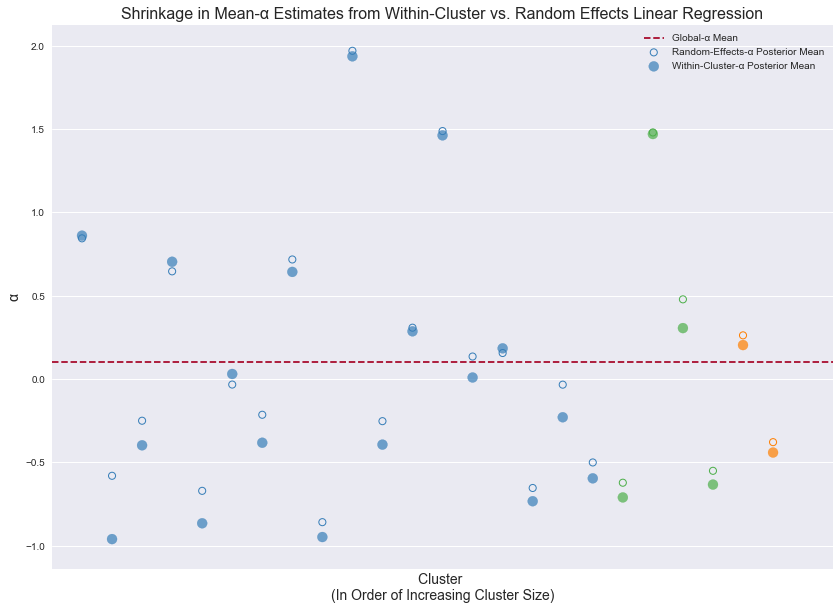

In [41]:
# plot shrinkage
plt.figure(figsize=(14, 10))
plt.xlim(-1, len(zip_codes_df) + 1)

plt.scatter(zip_codes_df.index, zip_codes_df['random_effects_posterior_means'], facecolors='none',
            edgecolors=zip_codes_df['cluster_size_color'], s=50, linewidth=1, 
            alpha=1, label='Random-Effects-α Posterior Mean')
plt.scatter(zip_codes_df.index, zip_codes_df['within_cluster_posterior_means'], c=zip_codes_df['cluster_size_color'], 
            s=100, alpha=.7, label='Within-Cluster-α Posterior Mean')
plt.axhline(global_intercept_posterior_mean, color='#A60628', linestyle='--', label='Global-α Mean')
plt.xticks([])
plt.xlabel('Cluster \n(In Order of Increasing Cluster Size)', fontsize=14)
plt.ylabel('α', fontsize=14)
plt.title('Shrinkage in Mean-α Estimates from Within-Cluster vs. Random Effects Linear Regression', fontsize=16)
plt.legend()

In [42]:
def neural_network(fixed_effects, λ=.001, input_dim=D):
    dense = Dense(5, activation='tanh', kernel_regularizer=l2(λ))(fixed_effects)
    output = Dense(1, activation='linear', name='output', kernel_regularizer=l2(λ))(dense)
    return K.squeeze(output, axis=1)

# model
fixed_effects = tf.placeholder(tf.float32, [N, D])
M_y = A + A_random_effects + neural_network(fixed_effects)
y = Normal(loc=M_y, scale=tf.ones(N))

In [43]:
latent_vars = {
    B_fixed_effects: qB_fixed_effects,
    A: qA,
    A_zip_code: qA_zip_code
}

sess.run(INIT_OP)
inference = ed.KLqp(latent_vars, data={fixed_effects: X_train, 
                                       zip_codes_ph: zip_codes[train_index], 
                                       y: y_train})

optimizer = tf.train.RMSPropOptimizer(0.01, epsilon=1.0)
inference.initialize(optimizer=optimizer)
inference.run(n_samples=5, n_iter=1000)

1000/1000 [100%] ██████████████████████████████ Elapsed: 16s | Loss: 537.211


In [44]:
param_posteriors = {
    B_fixed_effects: qB_fixed_effects.mean(),
    A: qA.mean(),
    A_zip_code: qA_zip_code.mean()
}
X_val_feed_dict = {
    fixed_effects: X_val,
    zip_codes_ph: zip_codes[val_index]
}
y_posterior = ed.copy(y, param_posteriors)

In [45]:
compute_MAE(y_posterior, X_val_feed_dict)

MAE on validation data: 0.52312


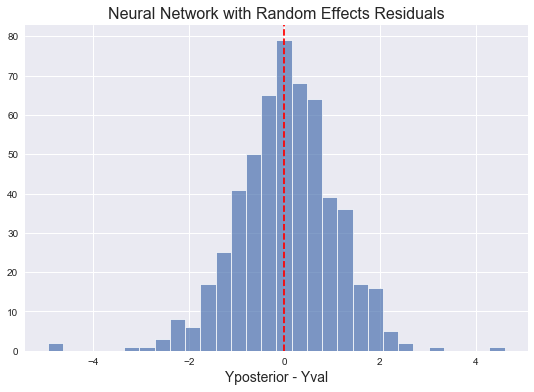

In [46]:
plot_residuals(y_posterior, X_val_feed_dict, 
               title='Neural Network with Random Effects Residuals')


In [326]:
data.columns

Index(['index', 'Id', 'MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea',
       'Street', 'LotShape', 'LandContour', 'Utilities', 'LotConfig',
       'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType',
       'HouseStyle', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd',
       'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType',
       'MasVnrArea', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual',
       'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1',
       'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating',
       'HeatingQC', 'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual',
       'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'GarageType', 'GarageYrBlt',
       'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual', 'GarageCond',
       'PavedDrive', 'WoodDeckSF'